<a href="https://colab.research.google.com/github/asadimtiazmalik/ML4SCI--Solution-Repository/blob/main/Simulating_Superfluid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It is important to set up the workspace before starting our simulation. For that we need install **PyAutolens** for simulating the super fluid dark matter.

In [1]:
!pip install autolens

     |████████████████████████████████| 184kB 14.4MB/s 
     |████████████████████████████████| 296kB 35.0MB/s 
     |████████████████████████████████| 389kB 39.0MB/s 
     |████████████████████████████████| 1.6MB 45.9MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 174kB 50.7MB/s 
     |████████████████████████████████| 512kB 46.1MB/s 
     |████████████████████████████████| 16.2MB 239kB/s 
     |████████████████████████████████| 27.4MB 160kB/s 
     |████████████████████████████████| 174kB 45.8MB/s 
     |████████████████████████████████| 1.3MB 39.4MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
     |████████████████████████████████| 92kB 10.6MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: autofit 0.74.0 has requirement scipy==1.5.2, but you'll have scipy 1.6.2 which is incompatible.


In [3]:
from os import path 
import autolens as al
import autolens.plot as aplt

For simulating an image we first need to model the telescope optics. That is done by convolving the image with a Point Spread Function.

In [33]:
psf = al.Kernel2D.from_gaussian(shape_native=(11, 11), sigma=0.1, pixel_scales=0.5)

We need to setup our Grid that will be deflected and traced by the lensing system

In [34]:
grid = al.Grid2D.uniform(shape_native = (150,150), pixel_scales = 0.1, sub_size = 2)

Strong Gravitational Lensing is done by setting up a light profile in the Source galaxy and a mass profile in a Lens galaxy. The viewer receives the light from source that is being deflected by the mass profile of the lens galaxy. 

Since we are dealing with vortex substructure of the superfluid dark matter which can also be considered as a string of mass where the mass density is constant through out the string. I will be passing a list of masses to `mass` object in `Lens Galaxy` where all the masses are equally seperated. This will give an affect of  a string with masses equally disrtibuted across it.

For that purpose I will make a dictionary called `vortex profile` where each key represents the point mass of the sub halo. All the subhalos together will give a feel of a string.  

To make the effects of the lensing more realistic I have given the lensing galaxy a light profile in addition to a mass profile.

In [35]:
vortex_profile = {}
for i in range(25):
  vortex_profile['linear mass ' + str(i)] = al.mp.PointMass(((0.0 + i/25), (0.0 +i/25)), einstein_radius = (((0.01)**0.5)/25) * 1.2)

As mentioned in the [Paper](https://arxiv.org/pdf/2008.12731.pdf), I have used 25 subhalos for this problem. Where each subhalo contains a point mass at an angle from the center. When considered all at once give a feel of a linearly arranged mass profile. Along with that the genral mass profile of the halo is `Spehrical Isothermal` as mentioned in the [Paper](https://arxiv.org/pdf/2008.12731.pdf).

In [36]:
# Lens Galaxy
lens_galaxy = al.Galaxy(
    redshift = 0.5,
    mass = al.mp.SphericalIsothermal(centre=(0, 0), einstein_radius=1.2),**dict(vortex_profile), 
    
    bulge = al.lp.EllipticalSersic(
        centre=(0.0, 0.0),
        elliptical_comps=(0.0, 0.111111),
        intensity=1.0,
        effective_radius=0.5,
        sersic_index=2.5,
    ),
    
)


The Source Galaxy contains an elliptical sersic ligth profile.

In [37]:
# Source Galaxy 
source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0, 0),
        elliptical_comps=(0.0, 0.111111),
        intensity=1.2,
        effective_radius=0.5,
        sersic_index=2.5,
    ),
)

In [38]:
# Tracer Object
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

The image below shows the plot of the ray traced by the plotter using the lens galaxy and the source galaxy. This shows how the superfluid appears. But as you can see this image is not realistic and also contains the light from the lens galaxy.

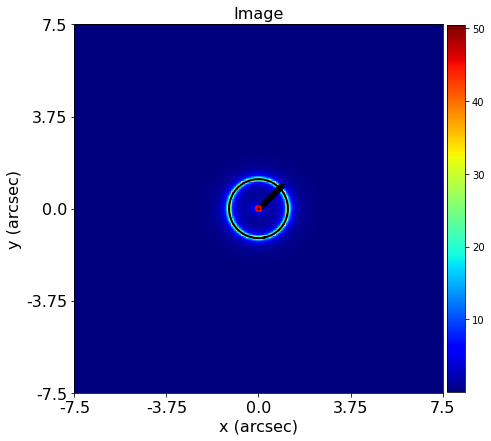

In [39]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures(image=True)

In [40]:
normal_image = tracer.image_from_grid(grid=grid)
padded_image = tracer.padded_image_from_grid_and_psf_shape(
    grid=grid, psf_shape_2d=psf.shape_native
)

print(normal_image.shape_native)
print(padded_image.shape_native)

(150, 150)
(160, 160)


Our simulator doesn't just plot the image but also gives it a real feel. As if the image was viewed from earth. Therefore, background noise is added to the `Simulator` object.

In [41]:
simulator = al.SimulatorImaging(
    exposure_time=300.0, psf=psf, background_sky_level=0.1, add_poisson_noise=True
)

imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

The cell below shows the result of our simulation.

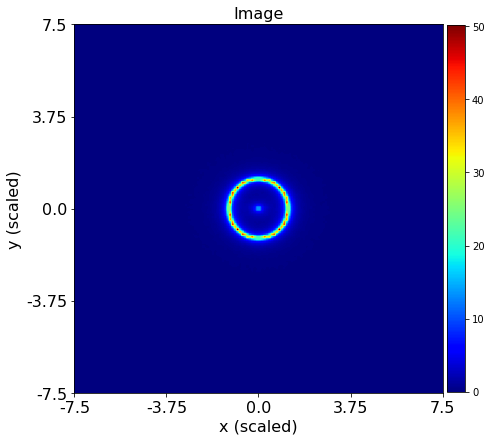

In [42]:
imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.figures(image=True)

Inorder to filter out the background noise from the image we must develope a mask. 

In [43]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=1,
    radius=2.5,
)

In [44]:
masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

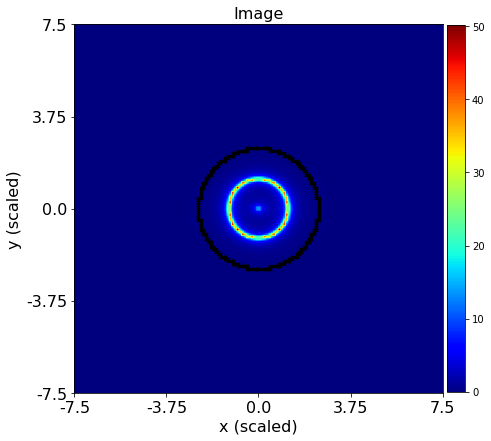

In [45]:
visuals_2d = aplt.Visuals2D(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.figures(image=True)

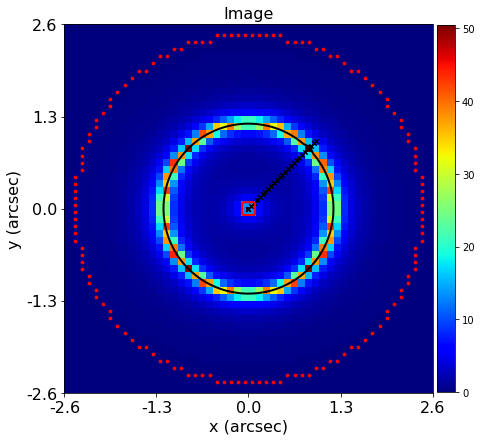

In [47]:
# Lens Galaxy
lens_galaxy = al.Galaxy(
    redshift = 0.5,
    mass = al.mp.SphericalIsothermal(centre=(0, 0), einstein_radius=1.2),**dict(vortex_profile), 
    
    bulge = al.lp.EllipticalSersic(
        centre=(0.0, 0.0),
        elliptical_comps=(0.0, 0.111111),
        intensity=1.0,
        effective_radius=0.5,
        sersic_index=2.5,
    ),
    
)


# Source Galaxy 
source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0, 0),
        elliptical_comps=(0.0, 0.111111),
        intensity=1.2,
        effective_radius=0.5,
        sersic_index=2.5,
    ),
)

# Tracer Object
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=masked_imaging.grid)
tracer_plotter.figures(image=True)


To see how well our lens performed in simulating the image we need to fit the images. This gives us the diagnostics of how well our simulator performed.

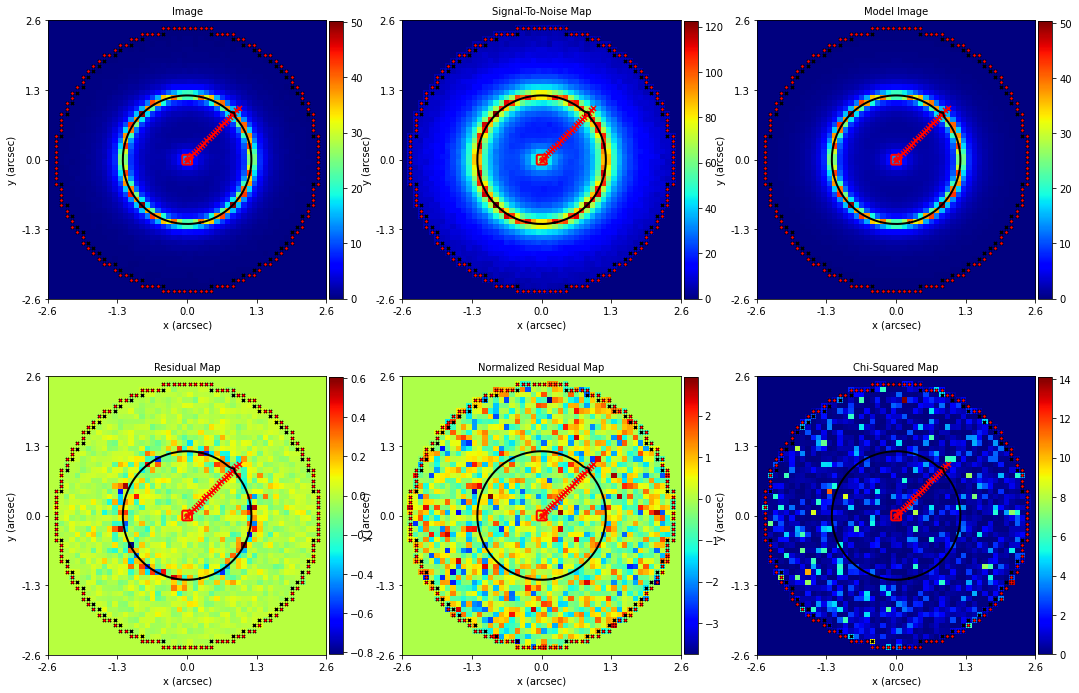

In [48]:
fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

A good simulation usually has a high `log_likelihood` 

In [49]:
print(fit.log_likelihood)

2589.4783575734064


In [50]:
dataset_name = "vortex_profiles"
dataset_path = path.join("/content/drive", "MyDrive", "imaging", dataset_name)

imaging.output_to_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    overwrite = True,
)